## This notebook explores different ways to generate adjacency matrix

In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 31, 1518)
-----------------------
name: X_train
shape: (640, 31, 1395)
-----------------------
name: clip_sizes_test
shape: (2, 129)
-----------------------
name: clip_sizes_train
shape: (2, 127)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 1518)
-----------------------
name: sel_win_nums_train
shape: (1, 1395)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 1518)
-----------------------
name: y_train
shape: (1, 1395)
-----------------------
print sample EGG signal from one node:


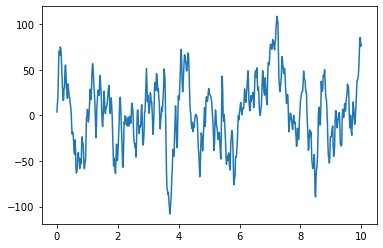

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_620.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
#from DataManager import get_label_variance as glv
#print(glv(dm.X_train, dm.Y_train))
#print(np.argsort(glv(dm.X_train, dm.Y_train)))
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
#dm.normalize()
print(dm)

X_train: shape of(1387, 31, 640)
X_test: shape of(1487, 31, 640)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(31, 31)
A_test: shape of(31, 31)
P_avg_train: shape of(31, 31)
P_avg_test: shape of(31, 31)
--------data successfully filtered (dvariance)--------
X_train: shape of(1387, 28, 31)
X_test: shape of(1487, 28, 31)
Y_train: shape of(1387, 1)
Y_test: shape of(1487, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


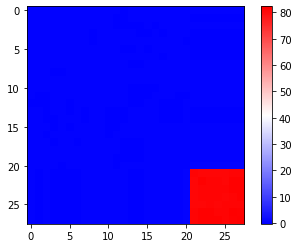

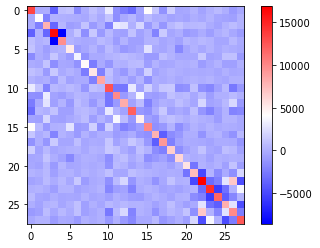

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

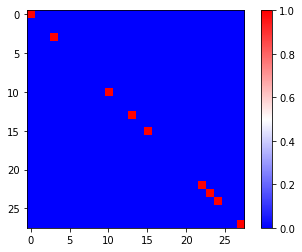

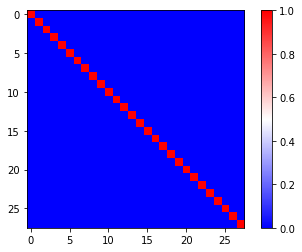

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

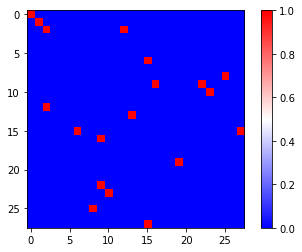

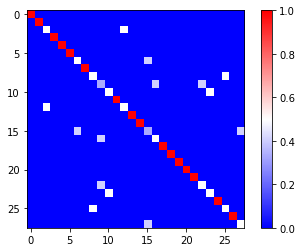

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

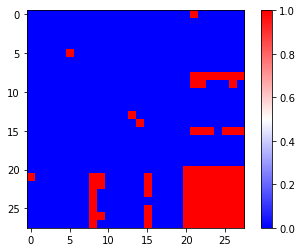

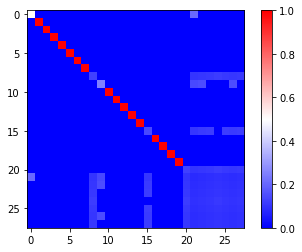

In [8]:
n = 0.1#1.3*10**-2
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [9]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 2,
    'num_epochs': 5,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 1,
    "N": 20,
    "b_tableau": GDEsolvers.RK4
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPparametersGDE = {
    'n_layers':2,
    'layer_size_factor':[1, 50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
#print(GCNparameters['M'])

  0%|          | 0/6 [00:00<?, ?it/s]

----------Training GCN-----------
device set to cpu
Epoch: 1   Batch: 6 of size 256   Train loss: 386.99853515625   Valid loss: 386.4026184082031375
Epoch: 2   Batch: 4 of size 256   Train loss: 383.7275695800781   Valid loss: 383.252563476562525

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 2   Batch: 6 of size 256   Train loss: 382.26593017578125   Valid loss: 381.9551086425781
Epoch: 3   Batch: 6 of size 256   Train loss: 378.6219482421875   Valid loss: 379.761718752584375
Epoch: 4   Batch: 3 of size 256   Train loss: 377.4261779785156   Valid loss: 378.90936279296875

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch: 4   Batch: 6 of size 256   Train loss: 376.7605285644531   Valid loss: 378.321502685546975
Epoch: 5   Batch: 6 of size 256   Train loss: 375.1788330078125   Valid loss: 377.89236450195315
----------Training Ends-----------
----------Training GDE-----------
device set to cpu


  9%|▉         | 1/11 [00:00<00:05,  1.97it/s]

 18%|█▊        | 2/11 [00:01<00:04,  1.95it/s]

 27%|██▋       | 3/11 [00:01<00:04,  1.94it/s]

 36%|███▋      | 4/11 [00:02<00:03,  1.93it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.92it/s]

 55%|█████▍    | 6/11 [00:03<00:02,  1.90it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.89it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.89it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.88it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

100%|██████████| 11/11 [00:05<00:00,  1.90it/s]

Epoch: 1   Batch: 11 of size 128   Train loss: 382.0528869628906   Valid loss: 382.5241394042969
----------Training Ends-----------


Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


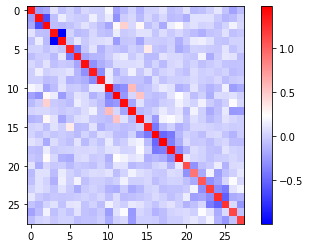

Average Non-Ictal


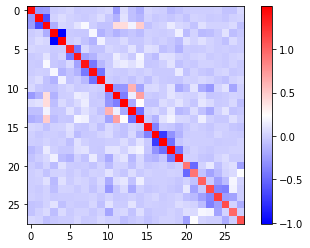

Average Ictal and Non-Ictal Simularity Matrix for GDE
Average ictal


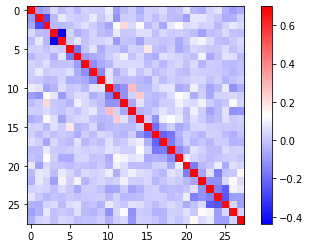

Average Non-Ictal


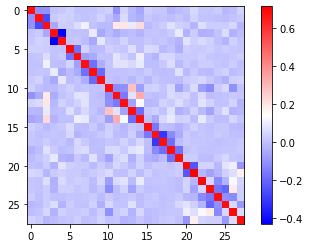

Sample Ictal and Non-Ictal Simularity Matrix for GCN
sample ictal


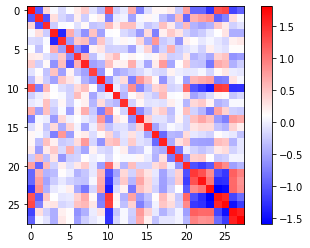

sample Non-Ictal


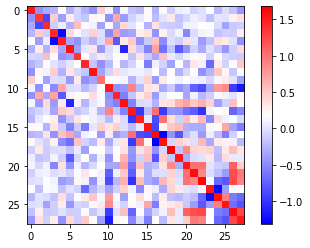

Sample Ictal and Non-Ictal Simularity Matrix for GDE
sample ictal


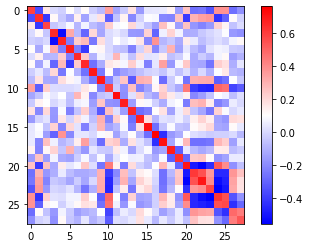

sample Non-Ictal


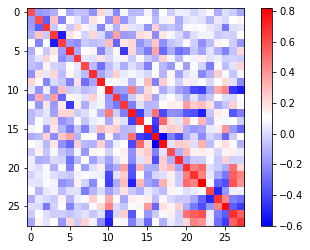

----------Training MLP-----------
0.72 ----------saved-----------
0.759 ----------saved-----------
0.778 ----------saved-----------
0.786 ----------saved-----------
0.789 ----------saved-----------
0.79 ----------saved-----------
0.792 ----------saved-----------
0.796 ----------saved-----------
0.8 ----------saved-----------
0.803 ----------saved-----------
0.805 ----------saved-----------
0.809 ----------saved-----------
0.812 ----------saved-----------
0.815 ----------saved-----------
0.817 ----------saved-----------
0.819 ----------saved-----------
0.82 ----------saved-----------
0.821 ----------saved-----------
0.822 ----------saved-----------
0.824 ----------saved-----------
0.826 ----------saved-----------
0.827 ----------saved-----------
0.827 ----------saved-----------
0.827 ----------saved-----------
0.828 ----------saved-----------
----------------------------------
0.615 ----------saved-----------
0.662 ----------saved-----------
0.693 ----------saved-----------
0.713 ------

In [11]:
IM = Integrated_Model(GCNparameters, GDEparameters, MLPparametersGCN, MLPparametersGDE, dm, create_DAD(Araw))

GCN accuracy:
device set to cuda
threshold: 0.05  validation loss: 0.3357 F1 accuracy 0.311 Precision accuracy 0.187 Recall accuracy 0.928 AUC accuracy: 0.828
device set to cuda
threshold: 0.1  validation loss: 0.3357 F1 accuracy 0.488 Precision accuracy 0.379 Recall accuracy 0.686 AUC accuracy: 0.828
device set to cuda
threshold: 0.15  validation loss: 0.3357 F1 accuracy 0.478 Precision accuracy 0.602 Recall accuracy 0.397 AUC accuracy: 0.828
device set to cuda
threshold: 0.2  validation loss: 0.3357 F1 accuracy 0.305 Precision accuracy 0.755 Recall accuracy 0.191 AUC accuracy: 0.828
device set to cuda
threshold: 0.25  validation loss: 0.3357 F1 accuracy 0.114 Precision accuracy 0.75 Recall accuracy 0.062 AUC accuracy: 0.828
device set to cuda
threshold: 0.3  validation loss: 0.3357 F1 accuracy 0.05 Precision accuracy 0.714 Recall accuracy 0.026 AUC accuracy: 0.828
device set to cuda
threshold: 0.35  validation loss: 0.3357 F1 accuracy 0.02 Precision accuracy 0.5 Recall accuracy 0.01 

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



device set to cuda
threshold: 0.45  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold: 0.5  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold: 0.55  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold: 0.6  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold: 0.65  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold: 0.7  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold: 0.75  validation loss: 0.3501 F1 accuracy 0.0 Precision accuracy 0.0 Recall accuracy 0.0 AUC accuracy: 0.796
device set to cuda
threshold:

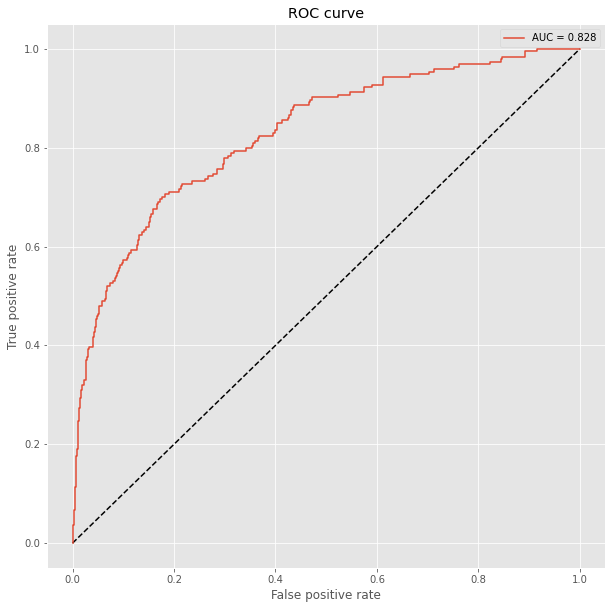

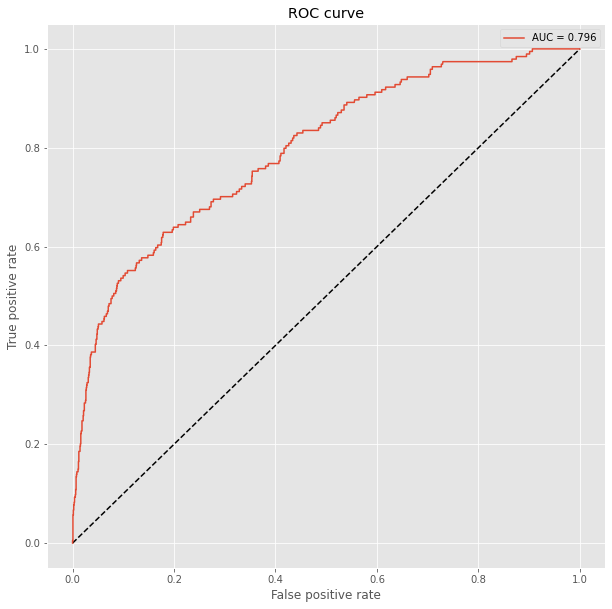

In [13]:
IM.print_accuracy(dm, Araw, device_name = 'cpu')